In [1]:
from typing import Dict,Callable

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import optim,Tensor,unsqueeze
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.autograd as autograd
import torch.nn as nn
from torchvision.models.resnet import resnet50,resnet18
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image
import torch.nn.functional as F

from mydataset import MyTrainDataset, my_dataset_worker_init_func

from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, write_gt_csv, read_gt_csv
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace, average_displacement_error_mean, final_displacement_error_mean
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

D:\Anaconda3\envs\lgsvl\lib\site-packages\l5kit\dataset\select_agents.py:32: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  "Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows."


# 数据处理

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "E:/Downloads/lyft-motion-prediction-autonomous-vehicles"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'mode': {'load_mode': False}, 'model_params': {'model_architecture': 'CVAE', 'latent_dim': 256, 'num_layers': 2, 'bidirectional': True, 'history_step_size': 1, 'history_num_frames': 49, 'future_step_size': 1, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_mode': 0, 'raster_size': [112, 112], 'pixel_size': [0.75, 0.75], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 32, 'shuffle': True, 'num_workers': 2}, 'val_data_loader': {'key': 'scenes/validate.zarr', 'batch_size': 32, 'shuffle': False, 'num_workers': 2}, 'train_params': {'device': 1, 'epochs': 1}}


In [3]:
if not cfg['mode']['load_mode']:    
    # ===== INIT DATASET
    train_cfg = cfg["train_data_loader"]
    rasterizer = build_rasterizer(cfg, dm)
    train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
    train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
    print(len(train_dataset))
    print(train_dataset)
    print(train_dataset[0].keys())

    train_dataset = MyTrainDataset(cfg, dm, len(train_dataset),raster_mode = cfg["raster_params"]["raster_mode"])
    train_dataloader = DataLoader(
        train_dataset,
        shuffle=train_cfg["shuffle"], 
        batch_size=train_cfg["batch_size"],
        num_workers=train_cfg["num_workers"],
        prefetch_factor = 2,
        pin_memory = True,
        persistent_workers=True,
        worker_init_fn=my_dataset_worker_init_func
    )

22496709
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history

# 参数

In [4]:
# 基本参数
if cfg["train_params"]["device"] == 1:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
torch.backends.cudnn.benchmark = True
epochs = cfg["train_params"]["epochs"]
latent_dim = cfg["model_params"]["latent_dim"]  # LSTM 的单元个数
encoder_fc = 64
num_layers = cfg["model_params"]["num_layers"]
bidirectional = cfg["model_params"]["bidirectional"]
num_classes = 3 # 类数
encoder_length = cfg["model_params"]["history_num_frames"]
decoder_length = cfg["model_params"]["future_num_frames"]
num_encoder_tokens = 2
num_decoder_tokens = 2
z_dimension = 32
accumulation_steps = 5 # 梯度累积步数

# 模型

In [5]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.lstm1 = nn.LSTM(num_encoder_tokens, latent_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        
        self.lstm2 = nn.LSTM(num_encoder_tokens, latent_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(latent_dim*(1+bidirectional), num_decoder_tokens)

    def forward(self, data):
        inputs1 = torch.FloatTensor(data["history_positions"]).to(device)
        if inputs1.dim() == 2:
            inputs1 = torch.unsqueeze(inputs1,0)

        h0 = torch.autograd.Variable(torch.randn(
            num_layers*(1+bidirectional), inputs1.size()[0], latent_dim)).to(device)
        c0 = torch.autograd.Variable(torch.randn(
            num_layers*(1+bidirectional), inputs1.size()[0], latent_dim)).to(device)

        _,(h,c) = self.lstm1(inputs1, (h0, c0))
        y_hat,(_,_) = self.lstm2(inputs1, (h, c))
        y_hat = torch.tanh(self.fc(y_hat))
        return y_hat


def loss_function(y_hat, data):
    y_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    y_true = data["target_positions"].to(device)
    MSE = F.mse_loss(y_hat, y_true, reduction='none')
    MSE = MSE * y_availabilities
    MSE = MSE.mean()
    return MSE


# 创建对象
cvae = CVAE().to(device)
cvae_optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-4)

In [6]:
if not cfg['mode']['load_mode']:    
    # ==== TRAIN LOOP
    losses_avg = []
    for epoch in range(epochs):  # 进行多个epoch的训练
        tr_it = iter(train_dataloader)
        progress_bar = tqdm(range(len(train_dataloader)//100),position=0)
        losses_train = []
        cvae_optimizer.zero_grad(set_to_none = True)
        for i in progress_bar:
            try:
                data = next(tr_it)
            except StopIteration:
                tr_it = iter(train_dataloader)
                data = next(tr_it)
            cvae.train() # 设置为训练模式
            torch.set_grad_enabled(True)
            y_hat = cvae(data)  # 输入
            if cfg["train_params"]["device"] == 1:
                with torch.cuda.amp.autocast():
                    loss = loss_function(y_hat, data)
            else:
                loss = loss_function(y_hat, data)

            # Backward pass
            # 梯度累积模式
            loss = loss / accumulation_steps
            loss.backward() 
            if (i+1) % accumulation_steps == 0:
                cvae_optimizer.step()
                cvae_optimizer.zero_grad(set_to_none = True)

            # 无梯度累积模式
    #         cvae_optimizer.zero_grad(set_to_none = True)
    #         loss.backward()
    #         cvae_optimizer.step()
            losses_train.append(loss.item())
            progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
        losses_avg.append(np.mean(losses_train))

loss: 12.946995735168457 loss(avg): 22.773940028905322: 100%|██████████████████████| 7030/7030 [23:25<00:00,  5.00it/s]


# 结果

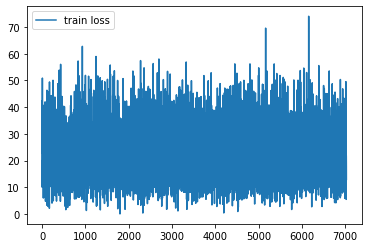

In [7]:
if not cfg['mode']['load_mode']:    
    torch.save(cvae.state_dict(),'E:/Downloads/cvae.pth')
    plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
    plt.legend()
    plt.show()

In [8]:
if not cfg['mode']['load_mode'] and cfg['train_params']['epochs'] > 1: 
    plt.plot(np.arange(len(losses_avg)), losses_avg, label="train loss")
    plt.legend()
    plt.show()

# 评估

In [9]:
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer)
print(len(eval_dataset))
print(eval_dataset[0].keys())

eval_dataset = MyTrainDataset(cfg, dm, len(eval_dataset),raster_mode = cfg["raster_params"]["raster_mode"])
eval_dataloader = DataLoader(
    eval_dataset,
    shuffle=eval_cfg["shuffle"], 
    batch_size=eval_cfg["batch_size"],
    num_workers=eval_cfg["num_workers"],
    prefetch_factor = 2,
    persistent_workers=True,
    pin_memory = True,
    worker_init_fn=my_dataset_worker_init_func
)

print(len(eval_dataloader))

21624612
dict_keys(['frame_index', 'image', 'target_positions', 'target_yaws', 'target_velocities', 'target_availabilities', 'history_positions', 'history_yaws', 'history_velocities', 'history_availabilities', 'world_to_image', 'raster_from_agent', 'raster_from_world', 'agent_from_world', 'world_from_agent', 'centroid', 'yaw', 'extent', 'history_extents', 'future_extents', 'curr_speed', 'scene_index', 'host_id', 'timestamp', 'track_id'])
675770


## 保存预测

In [10]:
# ==== EVAL LOOP
cvae.load_state_dict(torch.load('E:/Downloads/cvae.pth'))
cvae.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
gt_coords_offsets_pd = []
timestamps = []
agent_ids = []
availability = []
confs = []
tr_it = iter(eval_dataloader)
progress_bar = tqdm(range(len(eval_dataloader)//100),position=0)

for i in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(eval_dataloader)
        data = next(tr_it)
    y_hat = cvae(data)
#     print(data)
    # convert agent coordinates into world offsets
    agents_coords = y_hat.detach().cpu().numpy()
    gt_coords = data['target_positions'].numpy()
    world_from_agents = data['world_from_agent'].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]
    gt_offset = transform_points(gt_coords, world_from_agents) - centroids[:, None, :2]
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    gt_coords_offsets_pd.append(np.stack(gt_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    availability.append(data["target_availabilities"].numpy().copy())

    
pred_path = "E:/Downloads/pred.csv"
eval_gt_path = "E:/Downloads/gt.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

write_gt_csv(eval_gt_path,timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(gt_coords_offsets_pd),avails=np.concatenate(availability))

100%|██████████████████████████████████████████████████████████████████████████████| 6757/6757 [22:15<00:00,  4.71it/s]


## 预测结果

In [11]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [
                              neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)
    if metric_name=="time_displace":
        FDE = metric_mean
print('FDE1s: {}, FDE3s: {}, FDE5s: {}, ADE1s: {}, ADE3s: {}, ADE5s: {} '.format(
    FDE[9], FDE[29], FDE[49], np.mean(FDE[:10]), np.mean(FDE[:30]), np.mean(FDE[:50])))

neg_multi_log_likelihood 5605.5154354555825
time_displace [0.14934968 0.39351425 0.69960158 1.01122067 1.32256336 1.63201618
 1.93803149 2.2396201  2.53652848 2.82797827 3.11347802 3.39269309
 3.6658555  3.93297081 4.19425119 4.44860251 4.69664221 4.93859927
 5.17345784 5.4020932  5.62612583 5.84375523 6.05499292 6.26021491
 6.45951039 6.65461216 6.84393481 7.02697113 7.20337357 7.37527757
 7.5398536  7.70060671 7.85832902 8.00889419 8.1532449  8.29348225
 8.4291724  8.5609125  8.68753875 8.8113905  8.93152674 9.04927095
 9.16304907 9.27430196 9.38397673 9.49064446 9.59341601 9.69193193
 9.78827906 9.88101333]
FDE1s: 2.8279782674393172, FDE3s: 7.375277571746288, FDE5s: 9.881013329135396, ADE1s: 1.4750424064953362, ADE3s: 4.101927874387499, ADE5s: 5.986973426139153 


In [12]:
cvae.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_zarr, rasterizer)
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    predicted_positions1 = []
    predicted_positions2 = []
    predicted_positions3 = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]
        out_net = cvae(data_agent)
        out_net = out_net[0]
        out_pos = out_net.reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)


    plt.imshow(im_ego)
    plt.show()

KeyError: '11576254980902731486'